
 Training on snapshot 1/10: file_data_00_00_00.csv
[Epoch 001] Loss: 117.1371 | GW-Coverage: 0.00% | Cell-Coverage: 18.67%
[Epoch 002] Loss: 113.5447 | GW-Coverage: 5.56% | Cell-Coverage: 18.65%
[Epoch 003] Loss: 121.2344 | GW-Coverage: 3.70% | Cell-Coverage: 10.00%
[Epoch 004] Loss: 120.2610 | GW-Coverage: 1.85% | Cell-Coverage: 9.76%
[Epoch 005] Loss: 116.6308 | GW-Coverage: 1.85% | Cell-Coverage: 12.04%
[Epoch 006] Loss: 110.3584 | GW-Coverage: 11.11% | Cell-Coverage: 16.94%
[Epoch 007] Loss: 110.3358 | GW-Coverage: 5.56% | Cell-Coverage: 18.67%
[Epoch 008] Loss: 107.8092 | GW-Coverage: 20.37% | Cell-Coverage: 17.47%
[Epoch 009] Loss: 106.9801 | GW-Coverage: 20.37% | Cell-Coverage: 15.34%
[Epoch 010] Loss: 105.3976 | GW-Coverage: 22.22% | Cell-Coverage: 15.36%
[Epoch 011] Loss: 104.2701 | GW-Coverage: 25.93% | Cell-Coverage: 16.33%
[Epoch 012] Loss: 103.3176 | GW-Coverage: 24.07% | Cell-Coverage: 16.94%
[Epoch 013] Loss: 101.9670 | GW-Coverage: 29.63% | Cell-Coverage: 16.33%
[Epoch

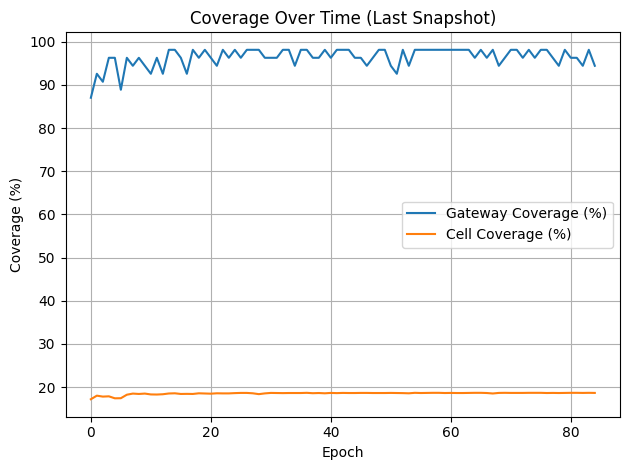

In [1]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Loss weights (customize as needed) ===
loss_weights = {
    'alpha': 10.0,     # Gateway coverage
    'beta': 1.0,      # Satellite exclusive assignment
    'gamma': 0.3,     # Demand fairness
    'delta': 100.0,    # Cell coverage
    'zeta': 0.5,      # Cell overload penalty
    'spatial': 0.0    # No spatial constraint for now
}

# === Select snapshot files (every 10th, up to 20 total) ===
all_files = sorted(os.listdir(folder_path))
snapshot_files = all_files[::10][:10]

model = None
optimizer = None

for idx, file in enumerate(snapshot_files):
    print(f"\n Training on snapshot {idx + 1}/{len(snapshot_files)}: {file}")

    # === Load and prepare graph ===
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells)

    # Normalize node features
    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)
    data = data.to(device)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Construct visibility matrices ===
    visibility_matrix = torch.zeros((num_sats, num_gws), device=device)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells), device=device)
    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
    for gw_idx, cell_idx in gw_to_cell.t():
        sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
        for s_idx in sats_connected:
            sat_id = sat_to_gw[0, s_idx]
            cell_visibility_matrix[sat_id, cell_idx] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)
    cell_coordinates = data['cell'].x[:, :2]

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands,
        'cell_coordinates': cell_coordinates
    }

    # === Initialize model once with snapshot-specific output sizes ===
    if model is None:
        model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # === Train ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10,
        verbose=True
    )

    # === Save history & model ===
    history_df = pd.DataFrame(history)
    history_file = f"training_history_snapshot_{idx+1:02d}.csv"
    history_df.to_csv(history_file, index=False)
    print(f" Saved training history: {history_file}")

    model_file = f"trained_model_snapshot_{idx+1:02d}.pt"
    torch.save(model.state_dict(), model_file)
    print(f" Saved model: {model_file}")

# === Plot final snapshot's coverage ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Testing Snapshot: 00_00_00 ===
Message Passing Rounds: 4
  Round 0: Cell Coverage = 100.00%
  Round 1: Cell Coverage = 100.00%
  Round 2: Cell Coverage = 100.00%
  Round 3: Cell Coverage = 100.00%
Final Satellite Demand (mean): -0.0820
Final Satellite Demand (std): 2.3263
Final Coverage: 100.00%


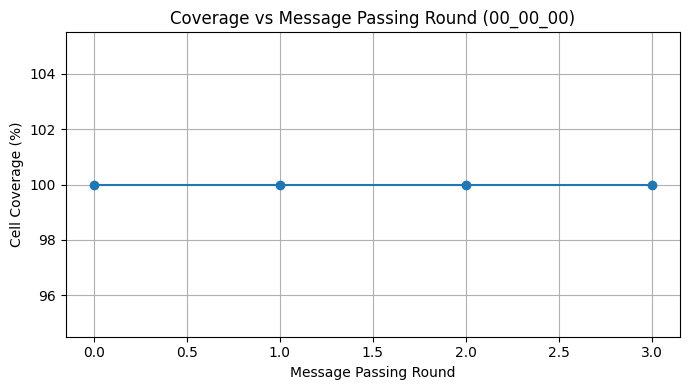


=== Testing Snapshot: 00_30_00 ===
Message Passing Rounds: 4
  Round 0: Cell Coverage = 100.00%
  Round 1: Cell Coverage = 100.00%
  Round 2: Cell Coverage = 100.00%
  Round 3: Cell Coverage = 100.00%
Final Satellite Demand (mean): -0.1859
Final Satellite Demand (std): 0.0873
Final Coverage: 100.00%


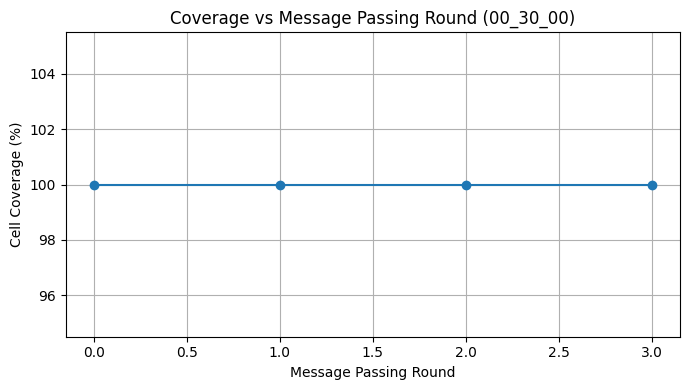

In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from torch.serialization import safe_globals
from torch.nn.parameter import UninitializedParameter

# === Config ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
model_path = "trained_model_snapshot_10.pt"
hidden_dim = 64
threshold = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Pick test snapshots ===
snapshot_files = sorted(os.listdir(folder_path))
test_snapshots = [snapshot_files[0], snapshot_files[90]]

# === Initialize model ===
dummy_data = build_hetero_graph(*load_all_data(folder_path, cell_file, gateway_file, test_snapshots[0]))
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=hidden_dim, num_gateways=num_gws, num_cells=num_cells).to(device)
with safe_globals([UninitializedParameter]):
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

for file in test_snapshots:
    snapshot_id = "_".join(os.path.splitext(file)[0].split("_")[-3:])
    print(f"\n=== Testing Snapshot: {snapshot_id} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, file)
    data = build_hetero_graph(satellites, gateways, cells).to(device)
    for nt in ['sat', 'gateway', 'cell']:
        data[nt].x = normalize(data[nt].x)

    # === Create cell visibility matrix ===
    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
    cell_visibility_matrix = torch.zeros((data['sat'].num_nodes, num_cells), device=device)
    for gw, cell in gw_to_cell.t():
        sats = (sat_to_gw[1] == gw).nonzero(as_tuple=True)[0]
        for s_idx in sats:
            cell_visibility_matrix[sat_to_gw[0, s_idx], cell] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1).to(device)

    with torch.no_grad():
        gw_logits_all, cell_logits_all, sat_demand_all = model(
            data=data,
            cell_visibility_matrix=cell_visibility_matrix,
            cell_demands=cell_demands
        )

    # === Track coverage per round ===
    coverages = []
    for logits in cell_logits_all:
        cell_probs = torch.sigmoid(logits)
        pred_cells = (cell_probs > threshold).int()
        covered = (pred_cells.sum(dim=0) > 0).float().mean().item()
        coverages.append(covered * 100)

    print(f"Message Passing Rounds: {len(cell_logits_all)}")
    for i, cov in enumerate(coverages):
        print(f"  Round {i}: Cell Coverage = {cov:.2f}%")

    # === Demand Stats ===
    final_demand = sat_demand_all[-1].squeeze().cpu()
    print(f"Final Satellite Demand (mean): {final_demand.mean():.4f}")
    print(f"Final Satellite Demand (std): {final_demand.std():.4f}")
    print(f"Final Coverage: {coverages[-1]:.2f}%")

    # === Plot Coverage ===
    plt.figure(figsize=(7, 4))
    plt.plot(range(len(coverages)), coverages, marker='o')
    plt.title(f"Coverage vs Message Passing Round ({snapshot_id})")
    plt.xlabel("Message Passing Round")
    plt.ylabel("Cell Coverage (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



=== Testing Snapshot: 00_00_00 ===
Message Passing Rounds: 4
  Round 0: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 1: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 2: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 3: Cell Coverage = 100.00%, Gateway Coverage = 79.63%
Final Satellite Demand (mean): -0.0820
Final Satellite Demand (std): 2.3263
Final Cell Coverage: 100.00%
Final Gateway Coverage: 79.63%


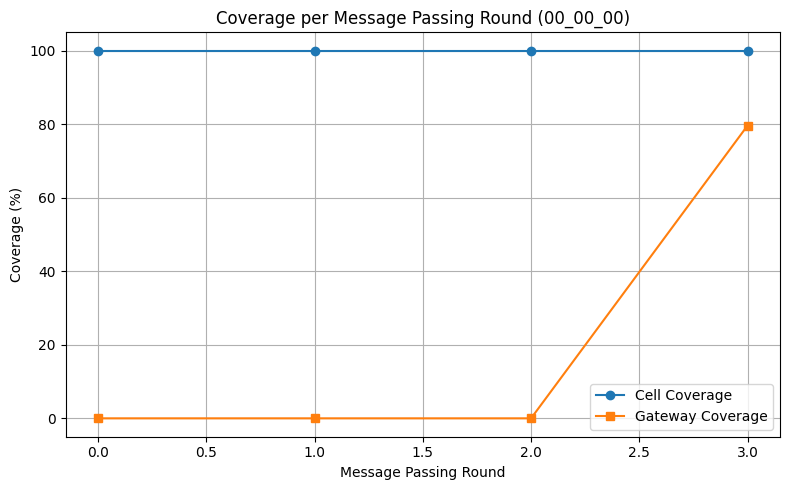


=== Testing Snapshot: 00_30_00 ===
Message Passing Rounds: 4
  Round 0: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 1: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 2: Cell Coverage = 100.00%, Gateway Coverage = 0.00%
  Round 3: Cell Coverage = 100.00%, Gateway Coverage = 98.15%
Final Satellite Demand (mean): -0.1859
Final Satellite Demand (std): 0.0873
Final Cell Coverage: 100.00%
Final Gateway Coverage: 98.15%


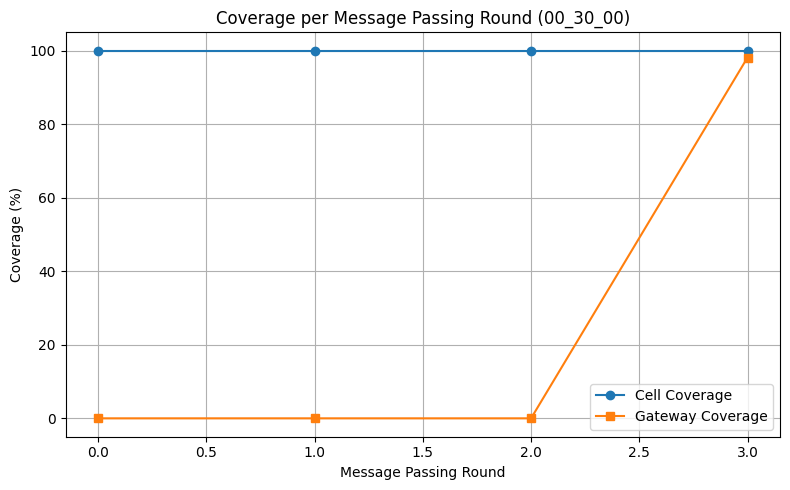

In [4]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from torch.serialization import safe_globals
from torch.nn.parameter import UninitializedParameter

# === Config ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
model_path = "trained_model_snapshot_10.pt"
hidden_dim = 64
threshold = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

def compute_gateway_coverage(gateway_probs, visibility_matrix):
    assignments = torch.sum(gateway_probs * visibility_matrix, dim=0)
    covered = (assignments >= 1).sum().item()
    return covered / visibility_matrix.shape[1]

# === Pick test snapshots ===
snapshot_files = sorted(os.listdir(folder_path))
test_snapshots = [snapshot_files[0], snapshot_files[90]]

# === Initialize model ===
dummy_data = build_hetero_graph(*load_all_data(folder_path, cell_file, gateway_file, test_snapshots[0]))
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=hidden_dim, num_gateways=num_gws, num_cells=num_cells).to(device)
with safe_globals([UninitializedParameter]):
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

for file in test_snapshots:
    snapshot_id = "_".join(os.path.splitext(file)[0].split("_")[-3:])
    print(f"\n=== Testing Snapshot: {snapshot_id} ===")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, file)
    data = build_hetero_graph(satellites, gateways, cells).to(device)
    for nt in ['sat', 'gateway', 'cell']:
        data[nt].x = normalize(data[nt].x)

    # === Create visibility matrices ===
    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index

    visibility_matrix = torch.zeros((data['sat'].num_nodes, num_gws), device=device)
    for s, g in sat_to_gw.t():
        visibility_matrix[s, g] = 1

    cell_visibility_matrix = torch.zeros((data['sat'].num_nodes, num_cells), device=device)
    for gw, cell in gw_to_cell.t():
        sats = (sat_to_gw[1] == gw).nonzero(as_tuple=True)[0]
        for s_idx in sats:
            cell_visibility_matrix[sat_to_gw[0, s_idx], cell] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1).to(device)

    with torch.no_grad():
        gw_logits_all, cell_logits_all, sat_demand_all = model(
            data=data,
            cell_visibility_matrix=cell_visibility_matrix,
            cell_demands=cell_demands
        )

    # === Track coverage per round ===
    cell_coverages = []
    gateway_coverages = []
    for gw_logits, cell_logits in zip(gw_logits_all, cell_logits_all):
        cell_probs = torch.sigmoid(cell_logits)
        pred_cells = (cell_probs > threshold).int()
        cell_cov = (pred_cells.sum(dim=0) > 0).float().mean().item()

        gateway_probs = torch.softmax(gw_logits, dim=1)
        gw_cov = compute_gateway_coverage(gateway_probs, visibility_matrix)

        cell_coverages.append(cell_cov * 100)
        gateway_coverages.append(gw_cov * 100)

    print(f"Message Passing Rounds: {len(cell_logits_all)}")
    for i, (cc, gc) in enumerate(zip(cell_coverages, gateway_coverages)):
        print(f"  Round {i}: Cell Coverage = {cc:.2f}%, Gateway Coverage = {gc:.2f}%")

    # === Demand Stats ===
    final_demand = sat_demand_all[-1].squeeze().cpu()
    print(f"Final Satellite Demand (mean): {final_demand.mean():.4f}")
    print(f"Final Satellite Demand (std): {final_demand.std():.4f}")
    print(f"Final Cell Coverage: {cell_coverages[-1]:.2f}%")
    print(f"Final Gateway Coverage: {gateway_coverages[-1]:.2f}%")

    # === Plot Coverage ===
    plt.figure(figsize=(8, 5))
    plt.plot(cell_coverages, marker='o', label="Cell Coverage")
    plt.plot(gateway_coverages, marker='s', label="Gateway Coverage")
    plt.title(f"Coverage per Message Passing Round ({snapshot_id})")
    plt.xlabel("Message Passing Round")
    plt.ylabel("Coverage (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"coverage_progress_{snapshot_id}.png", dpi=300)
    plt.show()


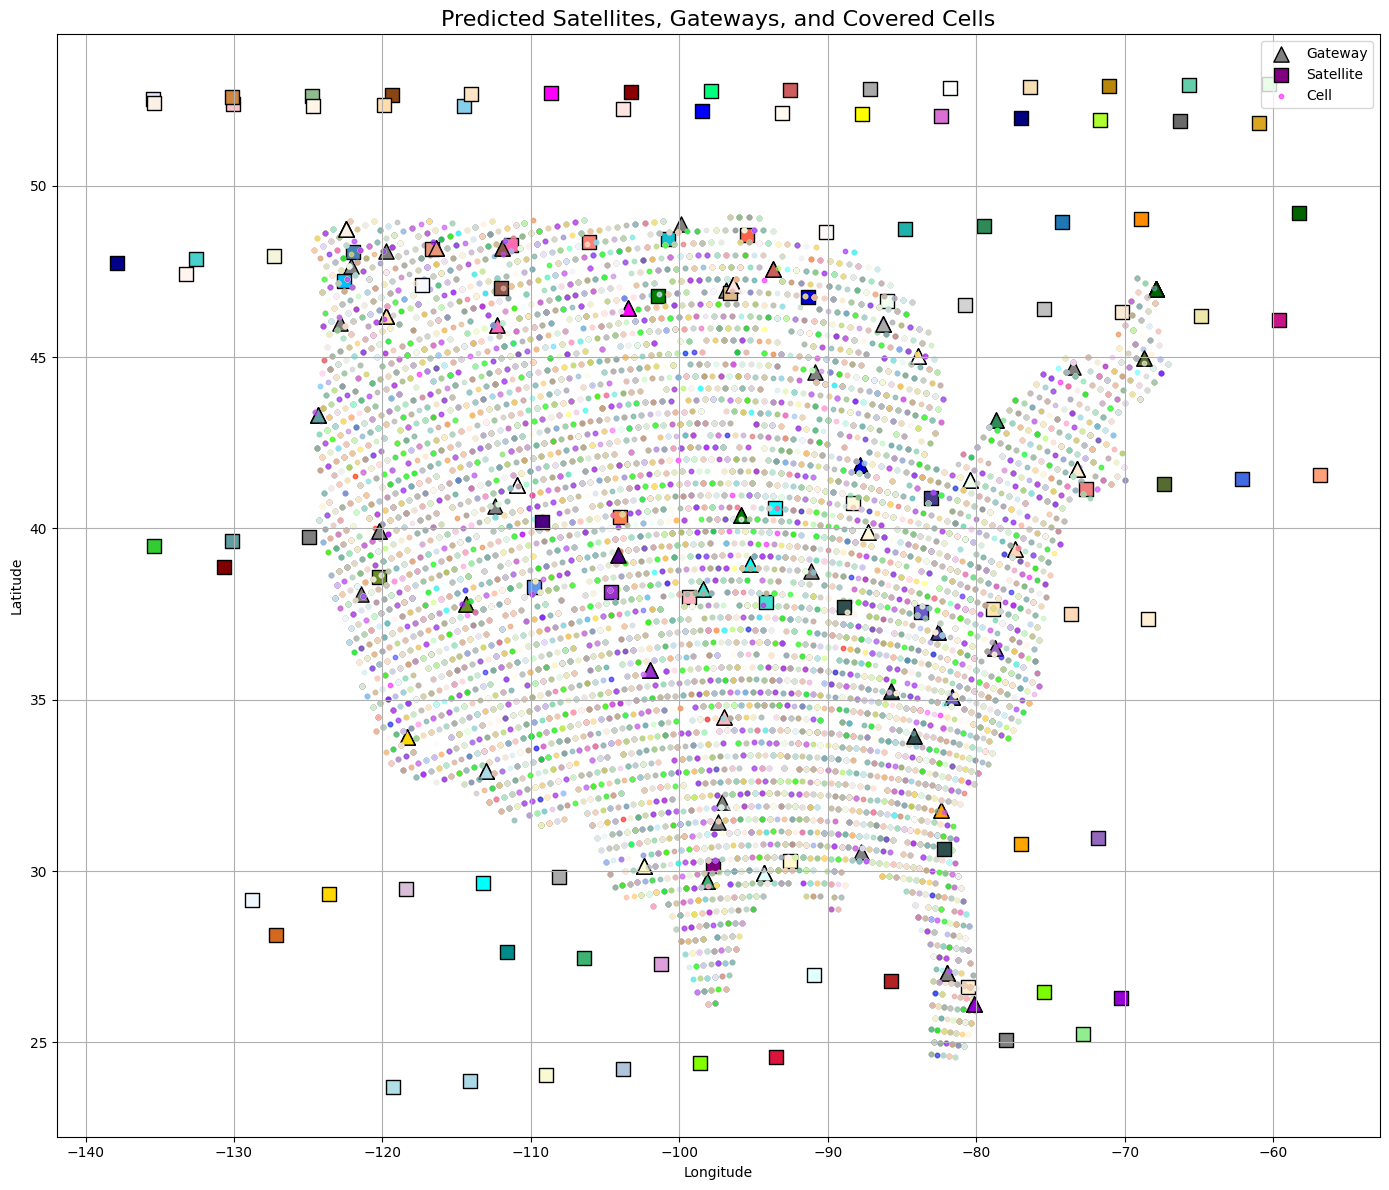

📍 Map saved: map_predicted_satellites_coverage_00_06_40.png
⚠️ Demand file not found. Skipping heatmap.


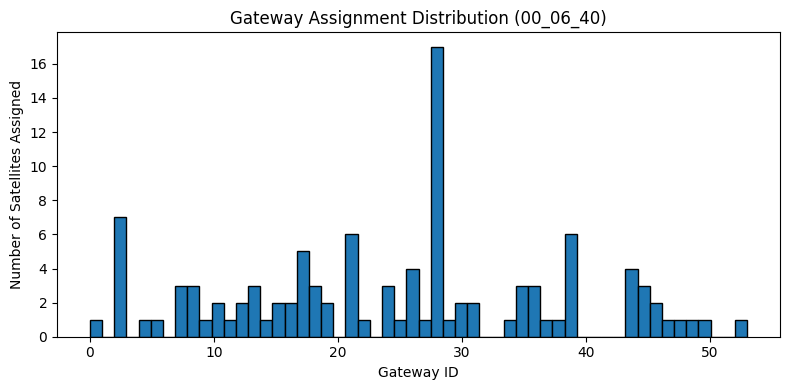

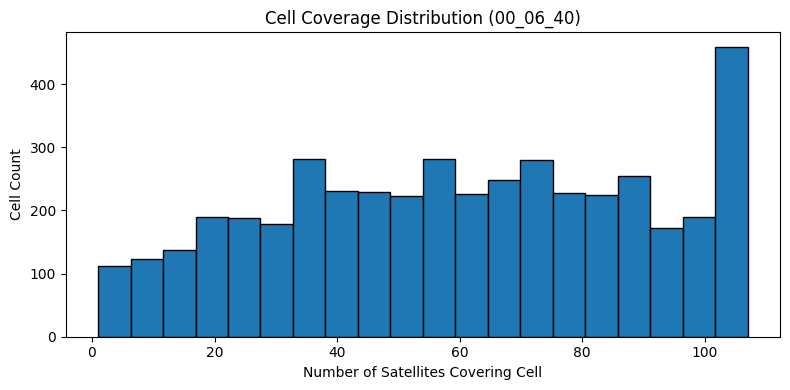

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval
import os

# === Setup ===
snapshot_id = "00_06_40"  # Change if needed
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
demand_file = f"sat_demand_{snapshot_id}.npy"  # Optional: if saved from test
cell_coverage_file = f"uncovered_cells_{snapshot_id}.csv"

cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse predicted_cells column ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Setup Color Map ===
num_sats = len(mapping_df)
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)
np.random.shuffle(color_list)
sat_color_map = {i: color_list[i % len(color_list)] for i in range(num_sats)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === MAIN PLOT: Satellite-Gateway-Cell Map ===
plt.figure(figsize=(14, 12))
MAX_CELLS_PER_SAT = 300

for _, row in gw_df.iterrows():
    plt.scatter(row['longitude'], row['latitude'], marker='^', color='gray', edgecolor='black', s=120, label='Gateway' if _ == 0 else "")

for idx, row in mapping_df.iterrows():
    sat_color = sat_color_map[idx]
    cell_color = lighten_color(sat_color, 0.4)

    plt.scatter(row['longitude'], row['latitude'], marker='s', color=sat_color, edgecolor='black', s=100, label='Satellite' if idx == 0 else "")

    gw_id = row['predicted_gateway']
    gw_row = gw_df[gw_df['gw_id'] == gw_id]
    if not gw_row.empty:
        plt.scatter(gw_row['longitude'], gw_row['latitude'], marker='^', color=sat_color, edgecolor='black', s=120)

    cell_ids = row['predicted_cells']
    if len(cell_ids) > MAX_CELLS_PER_SAT:
        cell_ids = np.random.choice(cell_ids, MAX_CELLS_PER_SAT, replace=False)

    valid_cells = cells_df.loc[cells_df.index.intersection(cell_ids)]
    plt.scatter(valid_cells['longitude'], valid_cells['latitude'],
                color=cell_color, s=10, alpha=0.6, label='Cell' if idx == 0 else "")

plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()
print(f"📍 Map saved: {map_file}")

# === HEATMAP: Satellite Demand (if available) ===
if os.path.exists(demand_file):
    demand = np.load(demand_file)
    plt.figure(figsize=(10, 5))
    plt.title(f"Satellite Demand Heatmap ({snapshot_id})")
    plt.xlabel("Satellite Index")
    plt.ylabel("Demand Value")
    plt.imshow(demand[np.newaxis, :], cmap="YlOrRd", aspect="auto")
    plt.colorbar(label="Demand")
    plt.tight_layout()
    plt.savefig(f"heatmap_sat_demand_{snapshot_id}.png", dpi=300)
    plt.show()
    print(f"🔥 Heatmap saved: heatmap_sat_demand_{snapshot_id}.png")
else:
    print("⚠️ Demand file not found. Skipping heatmap.")

# === HISTOGRAM: Gateway Assignments ===
plt.figure(figsize=(8, 4))
plt.hist(mapping_df['predicted_gateway'], bins=len(gw_df), edgecolor='black')
plt.title(f"Gateway Assignment Distribution ({snapshot_id})")
plt.xlabel("Gateway ID")
plt.ylabel("Number of Satellites Assigned")
plt.tight_layout()
plt.savefig(f"gateway_assignment_histogram_{snapshot_id}.png", dpi=300)
plt.show()

# === HISTOGRAM: Cell Coverage (if possible) ===
try:
    covered_cell_counts = pd.Series([cid for sub in mapping_df['predicted_cells'] for cid in sub])
    coverage_counts = covered_cell_counts.value_counts()
    plt.figure(figsize=(8, 4))
    plt.hist(coverage_counts, bins=20, edgecolor='black')
    plt.title(f"Cell Coverage Distribution ({snapshot_id})")
    plt.xlabel("Number of Satellites Covering Cell")
    plt.ylabel("Cell Count")
    plt.tight_layout()
    plt.savefig(f"cell_coverage_histogram_{snapshot_id}.png", dpi=300)
    plt.show()
except Exception as e:
    print("⚠️ Could not generate cell coverage histogram:", e)


Changinf loss to inlcude more spatial coverage 


=== Training on snapshot 1/10: file_data_00_00_00.csv ===
[Epoch 001] Loss: 117.2776 | GW-Coverage: 0.00% | Cell-Coverage: 18.67%
[Epoch 002] Loss: 115.2639 | GW-Coverage: 7.41% | Cell-Coverage: 18.67%
[Epoch 003] Loss: 119.1784 | GW-Coverage: 5.56% | Cell-Coverage: 11.23%
[Epoch 004] Loss: 115.4462 | GW-Coverage: 5.56% | Cell-Coverage: 13.74%
[Epoch 005] Loss: 111.5338 | GW-Coverage: 12.96% | Cell-Coverage: 18.49%
[Epoch 006] Loss: 109.5617 | GW-Coverage: 14.81% | Cell-Coverage: 18.28%
[Epoch 007] Loss: 107.8042 | GW-Coverage: 18.52% | Cell-Coverage: 16.26%
[Epoch 008] Loss: 106.7593 | GW-Coverage: 16.67% | Cell-Coverage: 15.85%
[Epoch 009] Loss: 105.2075 | GW-Coverage: 16.67% | Cell-Coverage: 16.96%
[Epoch 010] Loss: 104.1057 | GW-Coverage: 20.37% | Cell-Coverage: 17.36%
[Epoch 011] Loss: 102.6954 | GW-Coverage: 22.22% | Cell-Coverage: 16.61%
[Epoch 012] Loss: 101.6253 | GW-Coverage: 25.93% | Cell-Coverage: 15.21%
[Epoch 013] Loss: 100.3419 | GW-Coverage: 27.78% | Cell-Coverage: 15.

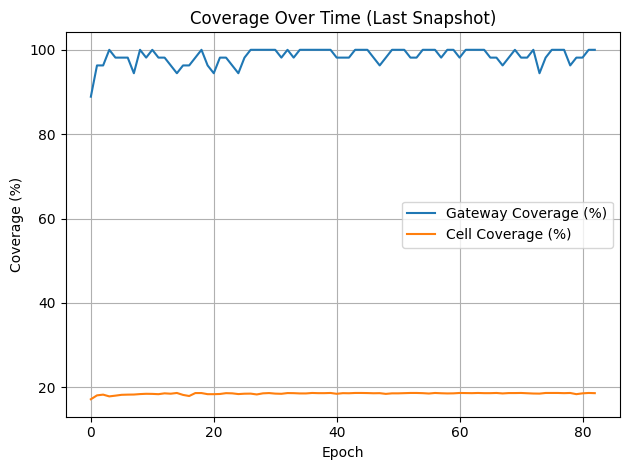

In [1]:
import os
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from src.loss2 import total_loss
from src.train_single import train_until_converged

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Loss weights with spatial clustering enabled ===
loss_weights = {
    'alpha': 10.0,     # Gateway coverage
    'beta': 1.0,       # Satellite exclusive assignment
    'gamma': 0.3,      # Demand fairness
    'delta': 100.0,    # Cell coverage
    'zeta': 0.5,       # Cell overload penalty
    'spatial': 0.01    # ✅ Enable spatial contiguity penalty
}

# === Select snapshot files (every 10th, up to 20 total) ===
all_files = sorted(os.listdir(folder_path))
snapshot_files = all_files[::10][:10]

model = None
optimizer = None

for idx, file in enumerate(snapshot_files):
    print(f"\n=== Training on snapshot {idx + 1}/{len(snapshot_files)}: {file} ===")

    # === Load and prepare graph ===
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells)

    # Normalize node features
    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)
    data = data.to(device)

    num_sats = data['sat'].num_nodes
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes

    # === Construct visibility matrices ===
    visibility_matrix = torch.zeros((num_sats, num_gws), device=device)
    for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
        visibility_matrix[src, dst] = 1

    cell_visibility_matrix = torch.zeros((num_sats, num_cells), device=device)
    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
    for gw_idx, cell_idx in gw_to_cell.t():
        sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
        for s_idx in sats_connected:
            sat_id = sat_to_gw[0, s_idx]
            cell_visibility_matrix[sat_id, cell_idx] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1)
    cell_coordinates = data['cell'].x[:, :2]

    aux_inputs = {
        'visibility_matrix': visibility_matrix,
        'cell_visibility_matrix': cell_visibility_matrix,
        'cell_demands': cell_demands,
        'cell_coordinates': cell_coordinates
    }

    # === Initialize model once with snapshot-specific output sizes ===
    if model is None:
        model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

    # === Train ===
    model, history = train_until_converged(
        model=model,
        data=data,
        optimizer=optimizer,
        aux_inputs=aux_inputs,
        loss_weights=loss_weights,
        epochs=100,
        patience=10,
        verbose=True
    )

    # Save only training history per snapshot
    history_df = pd.DataFrame(history)
    history_file = f"training_history_spatial_snapshot_{idx+1:02d}.csv"
    history_df.to_csv(history_file, index=False)
    print(f"✅ Saved training history: {history_file}")

# === Save final model after all snapshots ===
final_model_path = "trained_model_with_spatial.pt"
torch.save(model.state_dict(), final_model_path)
print(f"\n🎯 Final model saved as: {final_model_path}")

# === Plot final snapshot's coverage ===
plt.plot([x * 100 for x in history['gateway_coverage']], label='Gateway Coverage (%)')
plt.plot([x * 100 for x in history['cell_coverage']], label='Cell Coverage (%)')
plt.xlabel('Epoch')
plt.ylabel('Coverage (%)')
plt.title('Coverage Over Time (Last Snapshot)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


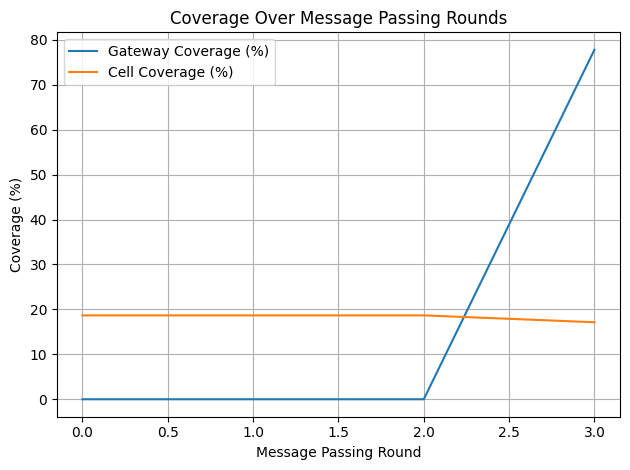

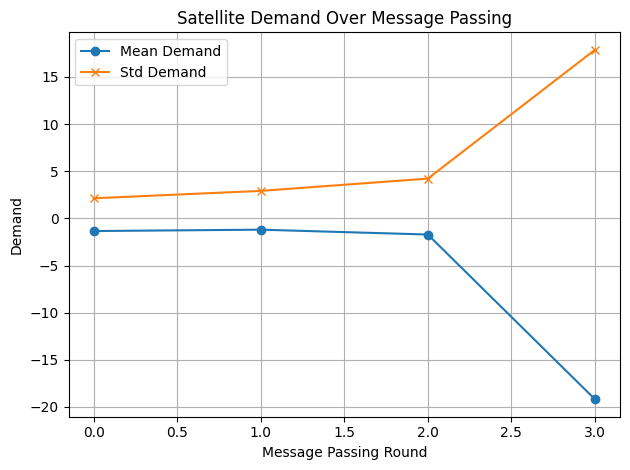

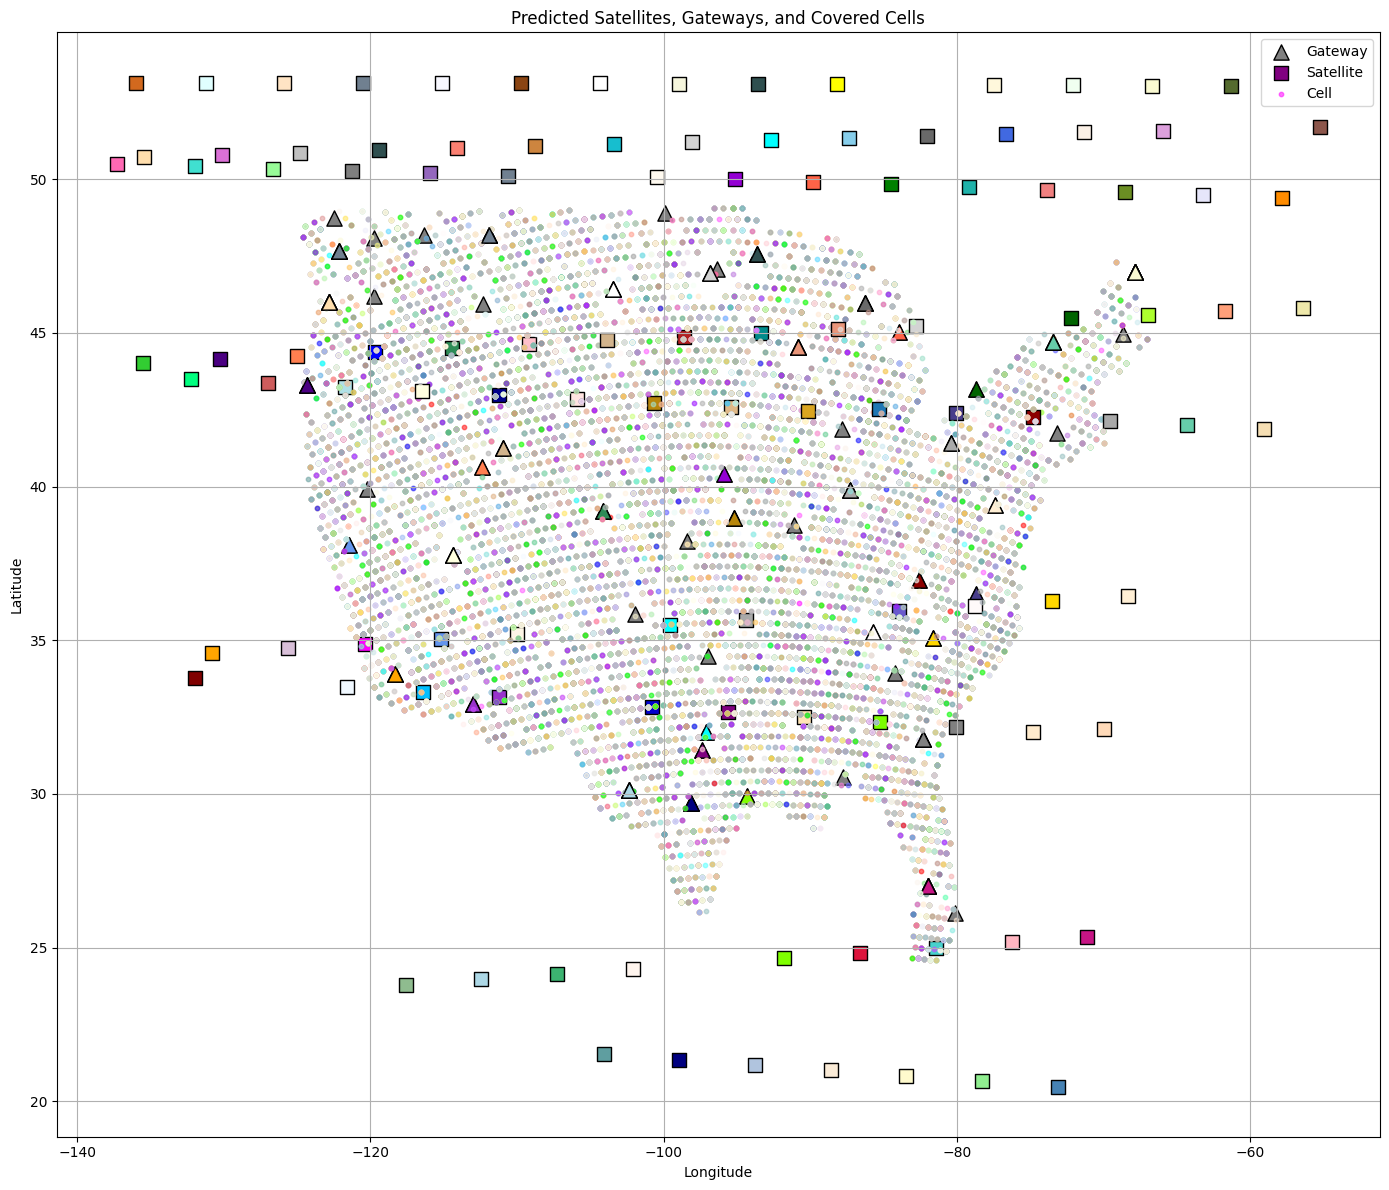

In [10]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from ast import literal_eval

# === CONFIG ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
cells_with_gw_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"
model_path = "trained_model_with_spatial.pt"
hidden_dim = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === SELECT FILE ===
snapshot_file = sorted(os.listdir(folder_path))[0]
snapshot_id = snapshot_file.split(".")[0]

# === LOAD STATIC DATA ===
gw_df = pd.read_csv(gateway_file)
cells_df = pd.read_csv(cells_with_gw_file, index_col="cell_id")

# === NORMALIZATION ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === COVERAGE METRICS ===
def compute_coverage(gw_probs, cell_probs, vis_matrix, cell_vis_matrix):
    gw_cov = (torch.sum(gw_probs * vis_matrix, dim=0) >= 1).sum().item() / vis_matrix.shape[1]
    cell_cov = (torch.sum(cell_probs * cell_vis_matrix, dim=0) >= 1).sum().item() / cell_vis_matrix.shape[1]
    return gw_cov, cell_cov

# === LIGHTEN COLOR ===
def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === LOAD DATA ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=snapshot_file)
sat_df = pd.DataFrame(satellites)
raw_sat_positions = sat_df[['longitude', 'latitude']].values

data = build_hetero_graph(satellites, gateways, cells)
for node_type in ['sat', 'gateway', 'cell']:
    data[node_type].x = normalize(data[node_type].x)
data = data.to(device)

num_sats = data['sat'].num_nodes
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

# === Build visibility ===
visibility_matrix = torch.zeros((num_sats, num_gws), device=device)
for src, dst in data['sat', 'connects', 'gateway'].edge_index.t():
    visibility_matrix[src, dst] = 1

cell_visibility_matrix = torch.zeros((num_sats, num_cells), device=device)
sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
for gw_idx, cell_idx in gw_to_cell.t():
    sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
    for s_idx in sats_connected:
        sat_id = sat_to_gw[0, s_idx]
        cell_visibility_matrix[sat_id, cell_idx] = 1

cell_demands = data['cell'].x[:, -1].unsqueeze(1).to(device)

# === LOAD MODEL ===
model = SatGatewayGNN(hidden_dim=hidden_dim, num_gateways=num_gws, num_cells=num_cells).to(device)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=False))
model.eval()

# === RUN MESSAGE PASSING ROUNDS ===
coverage_stats = []
demand_stats = []

with torch.no_grad():
    gw_logits_all, cell_logits_all, _ = model(
        data=data,
        cell_visibility_matrix=cell_visibility_matrix,
        cell_demands=cell_demands
    )

    for i in range(len(gw_logits_all)):
        gw_probs = torch.softmax(gw_logits_all[i], dim=1)
        cell_probs = torch.sigmoid(cell_logits_all[i])
        demand = torch.matmul(cell_probs, cell_demands).squeeze()

        gw_cov, cell_cov = compute_coverage(gw_probs, cell_probs, visibility_matrix, cell_visibility_matrix)
        coverage_stats.append((gw_cov, cell_cov))
        demand_stats.append((demand.mean().item(), demand.std().item()))

# === PLOT COVERAGE ===
rounds = list(range(len(coverage_stats)))
gw_covs = [x[0] * 100 for x in coverage_stats]
cell_covs = [x[1] * 100 for x in coverage_stats]

plt.figure()
plt.plot(rounds, gw_covs, label='Gateway Coverage (%)')
plt.plot(rounds, cell_covs, label='Cell Coverage (%)')
plt.xlabel("Message Passing Round")
plt.ylabel("Coverage (%)")
plt.title("Coverage Over Message Passing Rounds")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("coverage_over_rounds.png")
plt.show()

# === PLOT DEMAND ===
means = [x[0] for x in demand_stats]
stds = [x[1] for x in demand_stats]

plt.figure()
plt.plot(rounds, means, marker='o', label='Mean Demand')
plt.plot(rounds, stds, marker='x', label='Std Demand')
plt.xlabel("Message Passing Round")
plt.ylabel("Demand")
plt.title("Satellite Demand Over Message Passing")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("demand_over_rounds.png")
plt.show()

# === PLOT MAP (FINAL ROUND) ===
final_gw_probs = torch.softmax(gw_logits_all[-1], dim=1).cpu()
final_cell_probs = torch.sigmoid(cell_logits_all[-1]).cpu()
pred_gateways = final_gw_probs.argmax(dim=1).numpy()
pred_cells = (final_cell_probs > 0.5).numpy()

mapping_records = []
for sat_id in range(num_sats):
    assigned_gw = int(pred_gateways[sat_id])
    covered_cells = np.where(pred_cells[sat_id])[0].tolist()
    mapping_records.append({
        'sat_id': sat_id,
        'latitude': raw_sat_positions[sat_id][1],
        'longitude': raw_sat_positions[sat_id][0],
        'predicted_gateway': assigned_gw,
        'predicted_cells': str(covered_cells)
    })

mapping_df = pd.DataFrame(mapping_records)
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)
np.random.shuffle(color_list)
sat_color_map = {i: color_list[i % len(color_list)] for i in range(len(mapping_df))}
MAX_CELLS_PER_SAT = 300

plt.figure(figsize=(14, 12))
for _, row in gw_df.iterrows():
    plt.scatter(row['longitude'], row['latitude'], marker='^', color='gray', edgecolor='black', s=120, label='Gateway' if _ == 0 else "")

for idx, row in mapping_df.iterrows():
    sat_color = sat_color_map[idx]
    cell_color = lighten_color(sat_color, 0.4)

    plt.scatter(row['longitude'], row['latitude'], marker='s', color=sat_color, edgecolor='black', s=100, label='Satellite' if idx == 0 else "")
    gw_row = gw_df[gw_df['gw_id'] == row['predicted_gateway']]
    if not gw_row.empty:
        plt.scatter(gw_row['longitude'], gw_row['latitude'], marker='^', color=sat_color, edgecolor='black', s=120)

    cell_ids = row['predicted_cells']
    if len(cell_ids) > MAX_CELLS_PER_SAT:
        cell_ids = np.random.choice(cell_ids, MAX_CELLS_PER_SAT, replace=False)
    valid_cells = cells_df.loc[cells_df.index.intersection(cell_ids)]
    plt.scatter(valid_cells['longitude'], valid_cells['latitude'], color=cell_color, s=10, alpha=0.6, label='Cell' if idx == 0 else "")

plt.title("Predicted Satellites, Gateways, and Covered Cells")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f"map_predicted_satellites_coverage_{snapshot_id}.png", dpi=300)
plt.show()


In [5]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN
from torch.serialization import safe_globals
from torch.nn.parameter import UninitializedParameter

# === Configurations ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
model_path = "trained_sat_gateway_model_multi_message.pt"
hidden_dim = 64
threshold = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Snapshots to test ===
snapshot_files = sorted(os.listdir(folder_path))
test_snapshots = [
    snapshot_files[0],    # unseen
    snapshot_files[90]    # seen
]

# === Setup model with correct shape ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_files[0])
dummy_data = build_hetero_graph(satellites, gateways, cells)
num_gws = dummy_data['gateway'].num_nodes
num_cells = dummy_data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=hidden_dim, num_gateways=num_gws, num_cells=num_cells).to(device)

# === Load model weights ===
with safe_globals([UninitializedParameter]):
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
model.eval()

# === Test loop ===
for file in test_snapshots:
    snapshot_id = "_".join(os.path.splitext(file)[0].split("_")[-3:])
    print(f"\nTesting snapshot: {file}")

    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=file)
    data = build_hetero_graph(satellites, gateways, cells).to(device)

    for node_type in ['sat', 'gateway', 'cell']:
        data[node_type].x = normalize(data[node_type].x)

    # === Construct visibility matrix ===
    cell_visibility_matrix = torch.zeros((data['sat'].num_nodes, num_cells), device=device)
    sat_to_gw = data['sat', 'connects', 'gateway'].edge_index
    gw_to_cell = data['gateway', 'serves', 'cell'].edge_index
    for gw_idx, cell_idx in gw_to_cell.t():
        sats_connected = (sat_to_gw[1] == gw_idx).nonzero(as_tuple=True)[0]
        for s_idx in sats_connected:
            sat_id = sat_to_gw[0, s_idx]
            cell_visibility_matrix[sat_id, cell_idx] = 1

    cell_demands = data['cell'].x[:, -1].unsqueeze(1).to(device)

    with torch.no_grad():
        gw_logits_all, cell_logits_all, sat_demand_all = model(
            data=data,
            cell_visibility_matrix=cell_visibility_matrix,
            cell_demands=cell_demands
        )

    # === Final predictions ===
    final_gw_logits = gw_logits_all[-1]
    final_cell_logits = cell_logits_all[-1]
    gw_probs = torch.softmax(final_gw_logits, dim=1)
    cell_probs = torch.sigmoid(final_cell_logits)

    sat_ids = [s['sat_id'] for s in satellites]
    lats = [s['latitude'] for s in satellites]
    lngs = [s['longitude'] for s in satellites]
    alts = [s['altitude'] for s in satellites]

    predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
    predicted_cells = (cell_probs > threshold).int()
    predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

    mapping_df = pd.DataFrame({
        'sat_id': sat_ids,
        'latitude': lats,
        'longitude': lngs,
        'altitude': alts,
        'predicted_gateway': predicted_gateways,
        'predicted_cells': predicted_cell_indices
    })
    mapping_df.to_csv(f"satellite_to_cells_mapping_{snapshot_id}.csv", index=False)
    print(f"Mapping saved: satellite_to_cells_mapping_{snapshot_id}.csv")

    assigned_gateways = set(predicted_gateways)
    uncovered_gateways = sorted(set(range(num_gws)) - assigned_gateways)

    covered_cells = (predicted_cells.sum(dim=0) > 0).nonzero(as_tuple=True)[0].tolist()
    uncovered_cells = sorted(set(range(num_cells)) - set(covered_cells))

    pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(f"uncovered_gateways_{snapshot_id}.csv", index=False)
    pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(f"uncovered_cells_{snapshot_id}.csv", index=False)

    print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
    print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")

    # === Satellite demand tracking per round ===
    for i, demand in enumerate(sat_demand_all):
        mean_demand = demand.mean().item()
        std_demand = demand.std().item()
        print(f"Round {i}: Mean demand per sat = {mean_demand:.4f}, Std = {std_demand:.4f}")

    print(f"Message passing rounds: {len(sat_demand_all)}")



Testing snapshot: file_data_00_00_00.csv


AttributeError: 'SatGatewayGNN' object has no attribute 'init_conv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval

# === Setup ===
snapshot_id = "00_06_40"  # <- or dynamically set this before the script
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse cell list column ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Setup Color Map: unique per satellite ===
num_sats = len(mapping_df)
color_list = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())
np.random.seed(42)
np.random.shuffle(color_list)
sat_color_map = {i: color_list[i % len(color_list)] for i in range(num_sats)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Prepare Plot ===
plt.figure(figsize=(14, 12))

# Plot gateways (triangles) - all once
for _, row in gw_df.iterrows():
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color='gray', edgecolor='black', s=120, label='Gateway' if _ == 0 else "")

# Limit cells per satellite to avoid overload
MAX_CELLS_PER_SAT = 300

# === Plot satellites and their cells ===
for idx, row in mapping_df.iterrows():
    sat_color = sat_color_map[idx]
    cell_color = lighten_color(sat_color, 0.4)

    # Plot satellite as square
    plt.scatter(row['longitude'], row['latitude'], marker='s',
                color=sat_color, edgecolor='black', s=100, label='Satellite' if idx == 0 else "")

    # Plot assigned gateway (again, but colored)
    gw_id = row['predicted_gateway']
    gw_row = gw_df[gw_df['gw_id'] == gw_id]
    if not gw_row.empty:
        plt.scatter(gw_row['longitude'], gw_row['latitude'], marker='^',
                    color=sat_color, edgecolor='black', s=120)

    # Plot covered cells
    cell_ids = row['predicted_cells']
    if len(cell_ids) > MAX_CELLS_PER_SAT:
        cell_ids = np.random.choice(cell_ids, MAX_CELLS_PER_SAT, replace=False)

    valid_cells = cells_df.loc[cells_df.index.intersection(cell_ids)]
    plt.scatter(valid_cells['longitude'], valid_cells['latitude'],
                color=cell_color, s=10, alpha=0.6, label='Cell' if idx == 0 else "")

# === Labels, Title, Save ===
plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()

map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()
print(f"Map saved: {map_file}")


In [ ]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize Function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select Snapshot File ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[0]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
print(f"\n📄 Using snapshot file: {selected_file}")

# === Load and Build Graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize Features ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load Trained Model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes
model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi_message.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Predict Assignments ===
threshold = 0.2
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]

predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).to(torch.int)
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

# === Save Full Mapping ===
prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})
csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f"✅ Mapping saved: {csv_path}")

# === Coverage Analysis ===
assigned_gateways = set(predicted_gateways)
all_gateways = set(range(num_gws))
uncovered_gateways = sorted(list(all_gateways - assigned_gateways))

covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(num_cells))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save Uncovered Gateways and Cells ===
gw_out_path = f"uncovered_gateways_{snapshot_id}.csv"
cell_out_path = f"uncovered_cells_{snapshot_id}.csv"

pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(gw_out_path, index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(cell_out_path, index=False)

# === Print Summary ===
print(f"\n Snapshot tested: {selected_file}")
print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")
print(f" Saved: {gw_out_path}, {cell_out_path}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval

# === File paths ===
#snapshot_id = "00_06_40"
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse cell list ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Color Setup ===
NUM_GATEWAYS = 54
from matplotlib import cm

# Use a larger colormap with many distinct colors
cmap = cm.get_cmap('tab20', NUM_GATEWAYS)  # You can try 'nipy_spectral', 'gist_rainbow', etc.
gateway_color_map = {i: cmap(i) for i in range(NUM_GATEWAYS)}


def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Prepare for plotting ===
plt.figure(figsize=(12, 10))

# Plot gateways (triangles)
for _, row in gw_df.iterrows():
    gw_id = int(row['gw_id'])
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=120)

# Limit cells per satellite to avoid plotting overload
MAX_CELLS_PER_SAT = 300

# Group by satellite
for _, row in mapping_df.iterrows():
    gateway = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(gateway, 'gray'), 0.4)

    # Satellite square
    plt.scatter(row['longitude'], row['latitude'], marker='s', c=[color], edgecolor='black', s=80)

    # Cells (dots) — batched plotting
    cells = row['predicted_cells']
    if len(cells) > MAX_CELLS_PER_SAT:
        cells = np.random.choice(cells, MAX_CELLS_PER_SAT, replace=False)

    cell_subset = cells_df.loc[cells].dropna()
    plt.scatter(cell_subset['longitude'], cell_subset['latitude'], color=color, s=10, alpha=0.6)

# === Final touches ===
plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()
print(f" Map saved: {map_file}")


In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File Paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"
cells_with_gws_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv"

# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Load Gateway and Cell Data ===
gw_df = pd.read_csv(gateway_file)
cells_df_full = pd.read_csv(cells_with_gws_path, index_col="cell_id")

# === Load Snapshot Files [100 to 104] ===
snapshot_files = sorted(os.listdir(folder_path))[100:105]

# === Load Model Once ===
model = None
threshold = 0.2

# === Color Setup ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Loop Over Snapshots ===
for selected_file in snapshot_files:
    snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
    print(f"\n📄 Processing snapshot: {selected_file}")

    # === Load and build graph ===
    satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
    data = build_hetero_graph(satellites, gateways, cells)

    # === Normalize Features ===
    data['sat'].x = normalize(data['sat'].x)
    data['gateway'].x = normalize(data['gateway'].x)
    data['cell'].x = normalize(data['cell'].x)

    # === Load Model if Needed ===
    num_gws = data['gateway'].num_nodes
    num_cells = data['cell'].num_nodes
    if model is None:
        model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
        model.load_state_dict(torch.load("trained_sat_gateway_model_multi_message.pt"))
        model.eval()

    # === Inference ===
    with torch.no_grad():
        gw_probs, cell_probs = model(data)

    # === Prepare Predictions ===
    sat_ids = [s['sat_id'] for s in satellites]
    lats = [s['latitude'] for s in satellites]
    lngs = [s['longitude'] for s in satellites]
    alts = [s['altitude'] for s in satellites]

    predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
    predicted_cells = (cell_probs > threshold).to(torch.int)
    predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

    # === Save Prediction Mapping ===
    mapping_df = pd.DataFrame({
        'sat_id': sat_ids,
        'latitude': lats,
        'longitude': lngs,
        'altitude': alts,
        'predicted_gateway': predicted_gateways,
        'predicted_cells': predicted_cell_indices
    })
    csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
    mapping_df.to_csv(csv_path, index=False)
    print(f"✅ Mapping saved: {csv_path}")

    # === Coverage Analysis ===
    assigned_gateways = set(predicted_gateways)
    all_gateways = set(range(num_gws))
    uncovered_gateways = sorted(list(all_gateways - assigned_gateways))

    covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
    all_cells = set(range(num_cells))
    uncovered_cells = sorted(list(all_cells - set(covered_cells)))

    pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(f"uncovered_gateways_{snapshot_id}.csv", index=False)
    pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(f"uncovered_cells_{snapshot_id}.csv", index=False)
    print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
    print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")

    # === Visualization ===
    mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
        lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

    plt.figure(figsize=(12, 10))

    # Plot gateways (triangles)
    for _, row in gw_df.iterrows():
        gw_id = int(row['gw_id'])
        plt.scatter(row['longitude'], row['latitude'], marker='^',
                    color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=120)

    # Satellites and covered cells
    MAX_CELLS_PER_SAT = 300
    for _, row in mapping_df.iterrows():
        gateway = row['predicted_gateway']
        color = lighten_color(gateway_color_map.get(gateway, 'gray'), 0.4)
        plt.scatter(row['longitude'], row['latitude'], marker='s', c=[color], edgecolor='black', s=80)

        cells = row['predicted_cells']
        if len(cells) > MAX_CELLS_PER_SAT:
            cells = np.random.choice(cells, MAX_CELLS_PER_SAT, replace=False)

        cell_subset = cells_df_full.loc[cells].dropna()
        plt.scatter(cell_subset['longitude'], cell_subset['latitude'], color=color, s=10, alpha=0.6)

    # Final touches
    plt.title(f"Snapshot {snapshot_id}: Predicted Satellites, Gateways, and Covered Cells", fontsize=14)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.tight_layout()
    map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
    plt.savefig(map_file, dpi=300)
    plt.close()
    print(f"🗺️ Map saved: {map_file}")


Testing stuff

In [ ]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize function ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select 11th file ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[100]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])

print(f"\n Using snapshot file: {selected_file}")

# === Load + build graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# Normalize node features
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes
model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi_message.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Save Mapping CSV ===
threshold = 0.5
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]
predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).to(torch.int)
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})

csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f" Saved: {csv_path}")


In [ ]:
print(snapshot_id)
print(prediction_df.head())

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from ast import literal_eval

# === File paths ===
#snapshot_id = "00_06_40"
mapping_file = f"satellite_to_cells_mapping_{snapshot_id}.csv"
cells_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells_with_gateways.csv", index_col="cell_id")
gw_df = pd.read_csv(r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv")
mapping_df = pd.read_csv(mapping_file)

# === Parse cell list ===
mapping_df['predicted_cells'] = mapping_df['predicted_cells'].apply(
    lambda x: list(map(int, literal_eval(x))) if isinstance(x, str) else [])

# === Color Setup ===
NUM_GATEWAYS = 54
base_colors = list(mcolors.TABLEAU_COLORS.values())
np.random.seed(42)
np.random.shuffle(base_colors)
gateway_color_map = {i: base_colors[i % len(base_colors)] for i in range(NUM_GATEWAYS)}

def lighten_color(color, amount=0.5):
    import colorsys
    try: c = mcolors.cnames[color]
    except: c = color
    r, g, b = mcolors.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return colorsys.hls_to_rgb(h, min(1, l + amount * (1 - l)), s)

# === Prepare for plotting ===
plt.figure(figsize=(12, 10))

# Plot gateways (triangles)
for _, row in gw_df.iterrows():
    gw_id = int(row['gw_id'])
    plt.scatter(row['longitude'], row['latitude'], marker='^',
                color=gateway_color_map.get(gw_id, 'gray'), edgecolor='black', s=120)

# Limit cells per satellite to avoid plotting overload
MAX_CELLS_PER_SAT = 300

# Group by satellite
for _, row in mapping_df.iterrows():
    gateway = row['predicted_gateway']
    color = lighten_color(gateway_color_map.get(gateway, 'gray'), 0.4)

    # Satellite square
    plt.scatter(row['longitude'], row['latitude'], marker='s', c=[color], edgecolor='black', s=80)

    # Cells (dots) — batched plotting
    cells = row['predicted_cells']
    if len(cells) > MAX_CELLS_PER_SAT:
        cells = np.random.choice(cells, MAX_CELLS_PER_SAT, replace=False)

    cell_subset = cells_df.loc[cells].dropna()
    plt.scatter(cell_subset['longitude'], cell_subset['latitude'], color=color, s=10, alpha=0.6)

# === Final touches ===
plt.title("Predicted Satellites, Gateways, and Covered Cells", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
map_file = f"map_predicted_satellites_coverage_{snapshot_id}.png"
plt.savefig(map_file, dpi=300)
plt.show()
print(f" Map saved: {map_file}")


In [ ]:
import os
import torch
import pandas as pd
from src.data_loader import load_all_data
from src.graph_builder import build_hetero_graph
from src.model import SatGatewayGNN

# === File paths ===
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"
cell_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\cells.csv"
gateway_file = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\gateways.csv"

# === Normalize ===
def normalize(x):
    return (x - x.mean(dim=0)) / (x.std(dim=0) + 1e-6)

# === Select snapshot #20 ===
snapshot_files = sorted(os.listdir(folder_path))
selected_file = snapshot_files[100]
snapshot_id = "_".join(os.path.splitext(selected_file)[0].split("_")[-3:])
print(f"\n📄 Using snapshot file: {selected_file}")

# === Load and build graph ===
satellites, gateways, cells = load_all_data(folder_path, cell_file, gateway_file, snapshot_filename=selected_file)
data = build_hetero_graph(satellites, gateways, cells)

# === Normalize features ===
data['sat'].x = normalize(data['sat'].x)
data['gateway'].x = normalize(data['gateway'].x)
data['cell'].x = normalize(data['cell'].x)

# === Load trained model ===
num_gws = data['gateway'].num_nodes
num_cells = data['cell'].num_nodes

model = SatGatewayGNN(hidden_dim=64, num_gateways=num_gws, num_cells=num_cells)
model.load_state_dict(torch.load("trained_sat_gateway_model_multi_message.pt"))
model.eval()

# === Inference ===
with torch.no_grad():
    gw_probs, cell_probs = model(data)

# === Predict assignments ===
threshold = 0.5
sat_ids = [s['sat_id'] for s in satellites]
lats = [s['latitude'] for s in satellites]
lngs = [s['longitude'] for s in satellites]
alts = [s['altitude'] for s in satellites]

predicted_gateways = torch.argmax(gw_probs, dim=1).tolist()
predicted_cells = (cell_probs > threshold).to(torch.int)
predicted_cell_indices = [row.nonzero(as_tuple=True)[0].tolist() for row in predicted_cells]

# === Save full prediction map ===
prediction_df = pd.DataFrame({
    'sat_id': sat_ids,
    'latitude': lats,
    'longitude': lngs,
    'altitude': alts,
    'predicted_gateway': predicted_gateways,
    'predicted_cells': predicted_cell_indices
})
csv_path = f"satellite_to_cells_mapping_{snapshot_id}.csv"
prediction_df.to_csv(csv_path, index=False)
print(f"✅ Mapping saved: {csv_path}")

# === Coverage Analysis ===
assigned_gateways = set(predicted_gateways)
all_gateways = set(range(num_gws))
uncovered_gateways = sorted(list(all_gateways - assigned_gateways))

covered_cells = (cell_probs > threshold).any(dim=0).nonzero(as_tuple=True)[0].tolist()
all_cells = set(range(num_cells))
uncovered_cells = sorted(list(all_cells - set(covered_cells)))

# === Save uncovered results ===
gw_out_path = f"uncovered_gateways_{snapshot_id}.csv"
cell_out_path = f"uncovered_cells_{snapshot_id}.csv"

pd.DataFrame({'uncovered_gateway_id': uncovered_gateways}).to_csv(gw_out_path, index=False)
pd.DataFrame({'uncovered_cell_id': uncovered_cells}).to_csv(cell_out_path, index=False)

# === Print summary ===
print(f"\n✅ Snapshot tested: {selected_file}")
print(f"Uncovered Gateways: {len(uncovered_gateways)} / {num_gws}")
print(f"Uncovered Cells: {len(uncovered_cells)} / {num_cells}")
print(f"📁 Saved: {gw_out_path}, {cell_out_path}")
